### 1. What if we take ResNET model and directly run on the data without any fine tuning?
Lets see which class the model assigns the images to. 

Method 1: resnet from transformers library by huggingface as image transformation required can be done more easily.  
Method 2: resnet from torch

### Method 1: huggingface transformers library
Ref: https://blog.roboflow.com/how-to-use-resnet-50/

In [5]:
# !pip install datasets
# !pip install transformers

In [15]:
from transformers import AutoImageProcessor, ResNetForImageClassification
import torch

In [12]:
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

##### Load an image

In [9]:
from PIL import Image

In [10]:
# #If running from colab
# from google.colab import drive
# drive.mount('/content/drive')

# data_folder = '/content/drive/MyDrive/CCAI 2024 Tutorials/1_LULC_ResNET50/data'

Mounted at /content/drive


In [7]:
#If running locally
data_folder = 'data/'

In [ ]:
input_size = 224

In [65]:
image_path = os.path.join(data_folder,'EuroSAT','2750','AnnualCrop','AnnualCrop_1000.jpg')
image = Image.open(image_path)

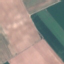

In [66]:
image

In [67]:
input = processor(image,return_tensors='pt')

In [68]:
# input

In [69]:
with torch.no_grad():
    logits = model(**input).logits

In [70]:
logits.argmax(-1)

tensor([858])

In [71]:
logits.shape

torch.Size([1, 1000])

In [72]:
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

tile roof


* The model doesn't know that these are satellite images, therefore the model is labeling it as objects which would optically look like the given image. 

* Try out for a few images to see some hilarious predictions! :D

Let's try through the torch method

### Method2 : resnet50 from torch

In [74]:
from torchvision import models

In [76]:
model = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
model.eval();

In [77]:
from torchvision import transforms

In [78]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
input_size = 224

In [79]:
test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean,imagenet_std)
    ]
)

In [80]:
input = test_transform(image)

In [81]:
output = model(input.unsqueeze(0))

In [94]:
output_classid = output.argmax(-1).item()

In [97]:
top5_prob, top5_id =torch.topk(output, 5) #https://pytorch.org/hub/pytorch_vision_resnet/


In [84]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2024-09-16 16:09:35--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2024-09-16 16:09:35 (36.4 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [89]:
with open("imagenet_classes.txt","r") as f:
    categories = [category.strip() for category in f.readlines()]

In [91]:
# categories

In [92]:
len(categories)

1000

In [95]:
categories[output_classid]

'Band Aid'

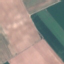

In [103]:
image

In [102]:
[categories[x] for x in top5_id[0]]

['Band Aid', 'knee pad', 'plastic bag', 'plane', 'Windsor tie']

**Observations**: 
1. Imagenet is not trained on satellite images, and also not on LULC classes, therefore giving these inputs to the model does not result in reasonable outputs.
2. Therefore, we do need to fine tune the model to get reasonable outputs. 